# Третье практическое задание

In [7]:
import numpy as np
import scipy
import sys
import math
from collections import Counter

from scipy.misc import logsumexp
from scipy.special import digamma, betaln, psi
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
class DPMixture():

    def __init__(self, X, alpha, a, b, T_const=10, pic_size=None):
        self.X = X
        self.alpha = alpha
        self.a = a
        self.b = b
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.T = T_const * int(alpha * np.log(1 + self.N / alpha))
        
        if pic_size == None:
            pic_size = 8
        self.pic_size = pic_size
        
        #theta consists of 2 fields (a and b parameters)
        self.theta = [np.zeros((self.T, self.D)) + self.a, np.zeros((self.T, self.D)) + self.b]
        
        #v consists of 2 fields (a and b parameters)
        self.v = [np.zeros(self.T) + 1., np.zeros(self.T) + self.alpha]
        
        self.z = np.ones((self.N, self.T)) / self.T
        
        print "DPMixture was created with params:"
        print "alpha = {0}, a = {1}, b = {2}".format(alpha, a, b)

    def initialize(self):
        self.z = np.random.rand(self.N, self.T)
        self.z /= self.z.sum(axis=1)[:, np.newaxis]

        #v consists of 2 fields (a and b parameters)
        self.v = [np.random.rand(self.T), np.random.rand(self.T)]

        #theta consists of 2 fields (a and b parameters)
        self.theta = [np.random.rand(self.T, self.D), np.random.rand(self.T, self.D)]
        
    def find_l(self):
        exp_q_z = psi(self.theta[0])*(self.theta[0] - 1) + \
                  psi(self.theta[1])*(self.theta[1] - 1) + \
                  psi(self.theta[0] + self.theta[1])*(self.theta[0] + self.theta[1] - 2)
                
        exp_q_v = psi(self.v[0])*(self.v[0] - 1) + \
                  psi(self.v[1])*(self.v[1] - 1) + \
                  psi(self.v[0] + self.v[1])*(self.v[0] + self.v[1] - 2)
                
        l_b = (self.v[1][:,np.newaxis] - self.theta[1]) * (psi(self.theta[1]) - psi(self.theta[1] + self.theta[0]))
        l_a = (self.v[0][:,np.newaxis] - self.theta[0]) * (psi(self.theta[0]) - psi(self.theta[1].sum() + self.theta[0].sum()))
        
        l_first = betaln(self.theta[0], self.theta[1]).sum()
        l_second = betaln(self.v[0], self.v[1]).sum()
        l_third = np.nan_to_num(self.z * np.log(self.z)).sum()        
        return l_first + l_second - l_third #- exp_q_z.sum() - exp_q_v.sum()

    def var_inference_step(self, display=True, max_iter=100, tol_L=1e-4):
        l_old, l_new = -np.inf, -np.inf
        for i in range(max_iter):
            #updating z
            z_first = self.X.dot(digamma(self.theta[0].T)) + (1 - self.X).dot(digamma(self.theta[1].T))
            z_second = digamma(self.theta[0].T + self.theta[1].T).sum(axis=0)
            z_third = digamma(self.v[0]) - digamma(self.v[0] + self.v[1])

            z_temp = z_first - z_second + z_third      
            z_temp[:, 1:] += np.cumsum(digamma(self.v[1][:-1])) - np.cumsum(digamma(self.v[0] + self.v[1])[:-1])

            self.z = np.exp(z_temp - logsumexp(z_temp, axis=1)[:, np.newaxis])
            
            #updating v
            z_all = self.z.sum(axis=0)
            self.v = [1 + self.z.sum(axis=0), self.alpha + z_all.sum() - np.cumsum(z_all)]
            
            #updating theta
            self.theta = [self.a + self.z.T.dot(self.X), self.b + self.z.T.dot(1 - self.X)]

            #counting L
            l_new = self.find_l()
            l_diff = l_new - l_old
            l_old = l_new
            
            if display:
                print("L: {0:.5f}, difference with prev step: {1:.5f}".format(l_new, l_diff))
                
            if l_diff < tol_L:
                break
        return l_new

    def var_inference(self, num_start=10, display=True, max_iter=100, tol_L=1e-4):
        best_step = [-np.inf, None]
        for i in range(num_start):
            if display:
                print("Step {0} started".format(i))
            self.initialize()
            l = self.var_inference_step(display, max_iter, tol_L)
            if l > best_step[0]:
                best_step[0] = l
                best_step[1] = [np.copy(self.z), np.copy(self.v), np.copy(self.theta)]
        self.z, self.v, self.theta = best_step[1]
        return self

    def add_sample(self, X):
        self.X = np.row_stack((self.X, X))
        self.N = len(self.X)
        
        #self.T = int(self.alpha * np.log(1 + self.N / self.alpha))
        self.z = np.random.rand(self.N, self.T)
        self.z /= self.z.sum(axis=1)[:, np.newaxis]
        
        self.v = [np.random.rand(self.T), np.random.rand(self.T)]
        
        cluster_dict = Counter(np.argmax(self.z, axis=1)).elements()
        old_clusters = np.unique(list(cluster_dict))
        old_clusters_num = len(old_clusters)
        
        self.theta[0][:old_clusters_num] = self.theta[0][old_clusters]
        self.theta[0][old_clusters_num:] = 1.0
        self.theta[1][:old_clusters_num] = self.theta[1][old_clusters]
        self.theta[1][old_clusters_num:] = 1.0

        return self

    def show_clusters(self):  
        clusters = Counter(np.argmax(self.z, axis=1))
        cl_max = len(clusters)
        if cl_max < 10:
            cols = cl_max
        else:
            cols = 10
            
        if cl_max == 1:
            f, ax = plt.subplots(figsize=(2, 2))
            ax.set_xticks(())
            ax.set_yticks(())
            i = np.unique(list(clusters.elements()))[0]
            ax.imshow((self.theta[0][i] / (self.theta[0][i] + self.theta[1][i])).reshape((self.pic_size, self.pic_size)), 'gray')
        
        else:      
            rows = int(math.ceil(cl_max * 1.0 / 10))
            f, axarr = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))

            for ax in axarr.flatten():
                ax.set_xticks(())
                ax.set_yticks(())

            for i, ax in zip(np.unique(list(clusters.elements())), axarr.flatten()):
                ax.imshow((self.theta[0][i] / (self.theta[0][i] + self.theta[1][i])).reshape((self.pic_size, self.pic_size)), 'gray')
                

def process(X, num_start=10, bound=None, alpha=2, a=0.95, b=0.88):
    if bound == None:
        bound = len(X)
    dp_mixture = DPMixture(X[:bound], alpha, a, b)
    dp_mixture.var_inference(num_start, display=False)
    dp_mixture.show_clusters()
    return dp_mixture.z
    
def count_accuracy_matrix(y_pred, y_test):
    matrix = np.zeros((10, 10))
    for i, value in enumerate(y_pred):
        matrix[value][y_test[i]] += 1
        
    f, ax = plt.subplots(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 22})
    heatmap = ax.pcolor(matrix, cmap=plt.cm.Blues)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')
    
    return matrix

Считываем данные и бинаризуем их по порогу:

In [62]:
digits = datasets.load_digits()
X = binarize(digits.data, threshold=8)
y = digits.target

##### Третий пункт

Попробуем разные значения $\alpha$ при фиксированных $a$ и $b$:

DPMixture was created with params:
alpha = 10, a = 2, b = 3


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in multiply


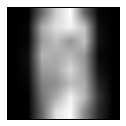

In [63]:
process(X, 10, 100, 10, 2, 3)

DPMixture was created with params:
alpha = 2, a = 0.3, b = 0.88
DPMixture was created with params:
alpha = 2, a = 0.5, b = 0.88
DPMixture was created with params:
alpha = 2, a = 0.7, b = 0.88
DPMixture was created with params:
alpha = 2, a = 0.9, b = 0.88
DPMixture was created with params:
alpha = 2, a = 1.1, b = 0.88


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in multiply


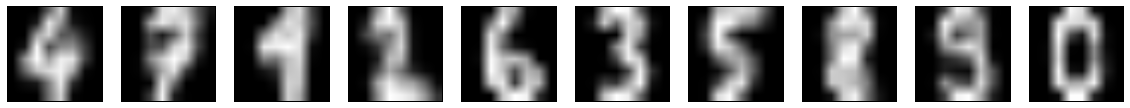

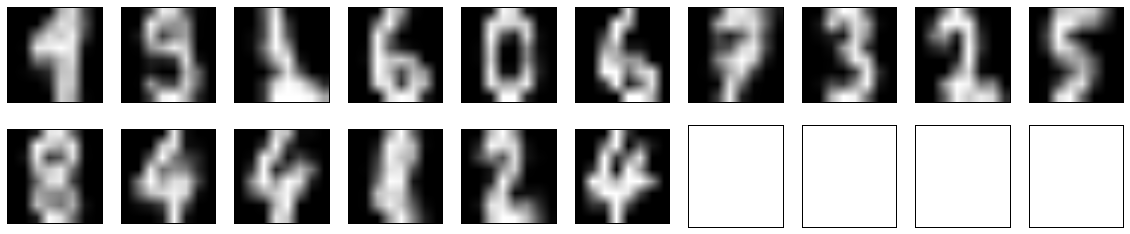

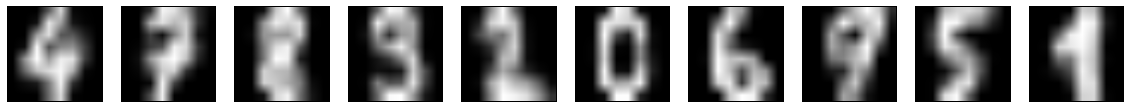

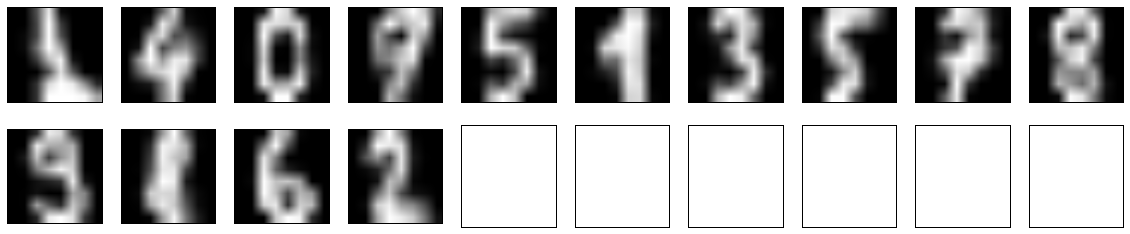

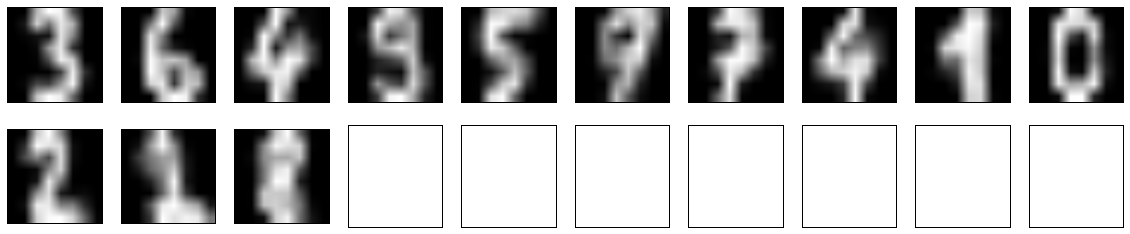

In [64]:
for a in [0.3, 0.5, 0.7, 0.9, 1.1]:
    process(X, 10, 1000, 2, a, 0.88)

DPMixture was created with params:
alpha = 2, a = 0.9, b = 0.3
DPMixture was created with params:
alpha = 2, a = 0.9, b = 0.5
DPMixture was created with params:
alpha = 2, a = 0.9, b = 0.7
DPMixture was created with params:
alpha = 2, a = 0.9, b = 0.9
DPMixture was created with params:
alpha = 2, a = 0.9, b = 1.1


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in multiply


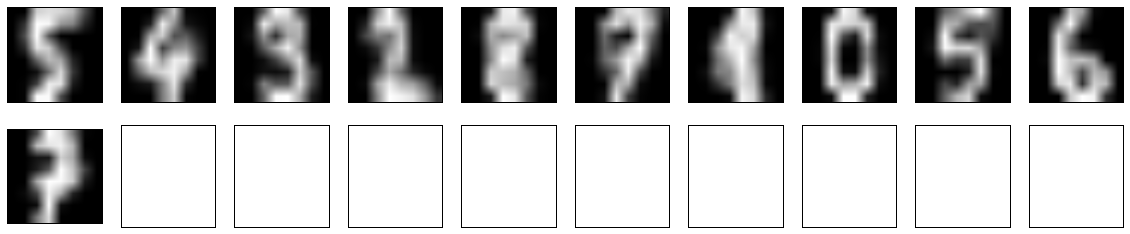

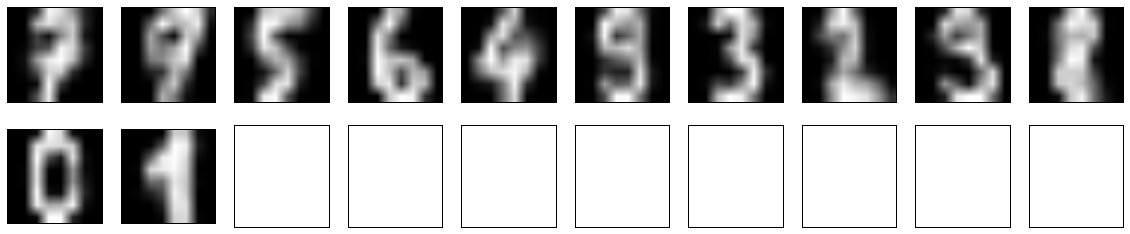

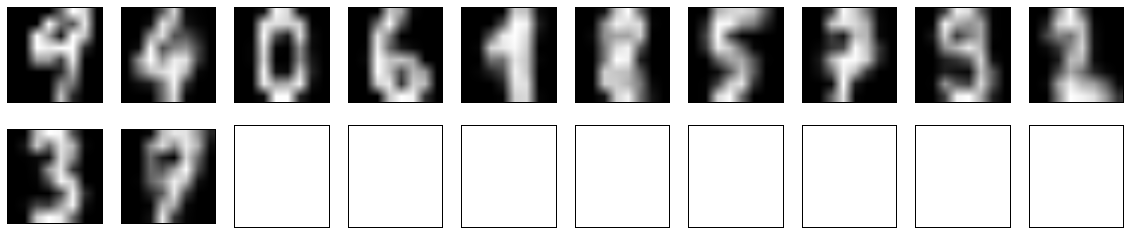

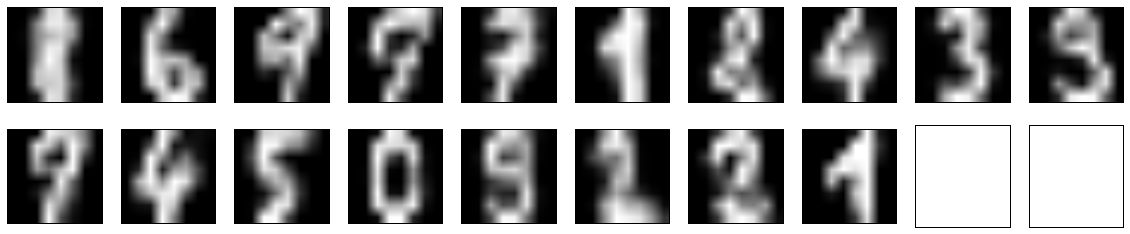

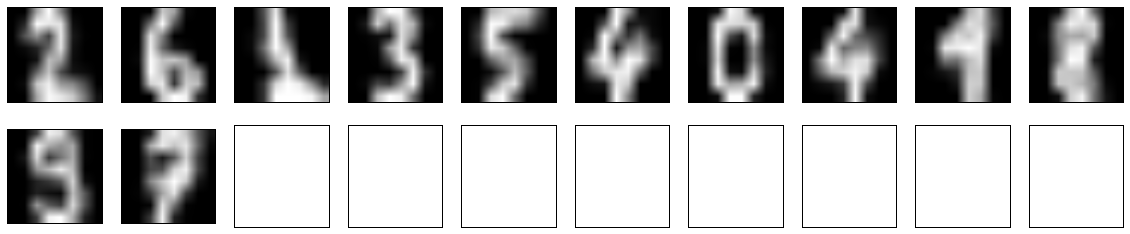

In [65]:
for b in [0.3, 0.5, 0.7, 0.9, 1.1]:
    process(X, 10, 1000, 2, 0.9, b)

Вот эти параметры дают адекватные результаты:

DPMixture was created with params:
alpha = 2.5, a = 0.99, b = 0.88


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in multiply


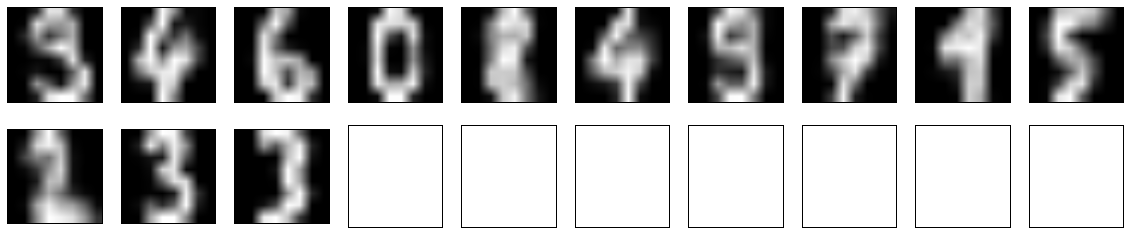

In [66]:
process(X, 10, 1000, 2.5, 0.99, 0.88)

Посмотрим, как влияет на результат кластеризации $\alpha$:

Alpha = 1, a = 0.99, b = 0.88
Alpha = 5, a = 0.99, b = 0.88
Alpha = 10, a = 0.99, b = 0.88
Alpha = 50, a = 0.99, b = 0.88


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:44: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:44: RuntimeWarning: invalid value encountered in multiply


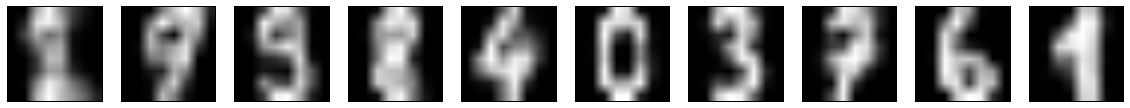

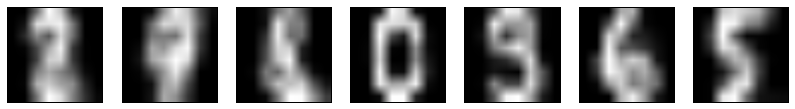

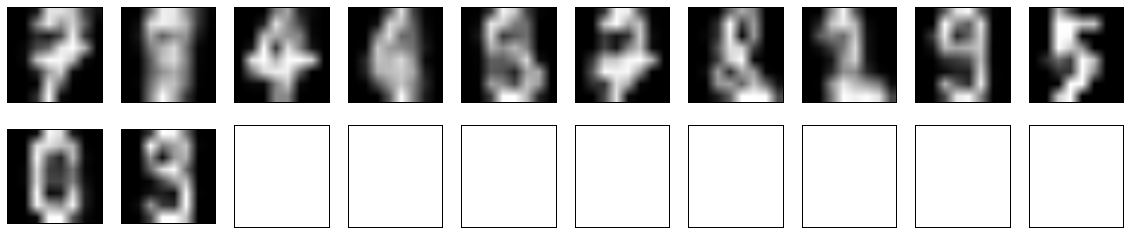

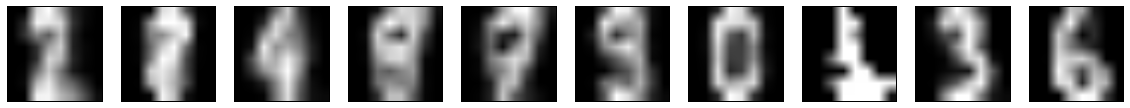

In [37]:
for alpha in [1, 5, 10, 50]:
    process(X, 10, 1000, alpha, 0.99, 0.88)

Alpha = 10, a = 0.1, b = 0.9


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:39: RuntimeWarning: invalid value encountered in multiply


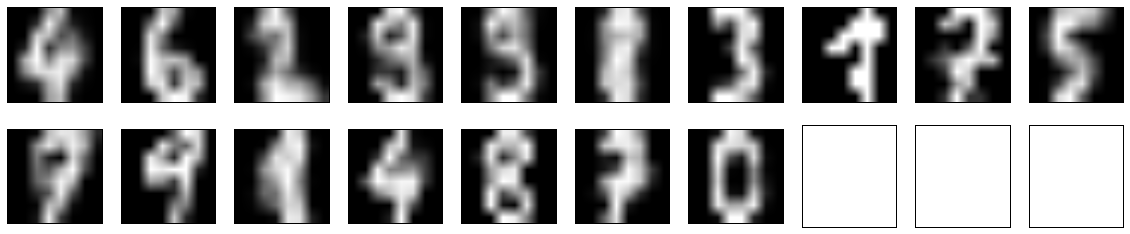

In [283]:
process(X, 10, 1000, 10, 0.1, 0.9)

##### Четвертый пункт

Запускаем алгоритм на полной выборке digits:

DPMixture was created with params:
alpha = 2.5, a = 0.99, b = 0.88


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:47: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:47: RuntimeWarning: invalid value encountered in multiply


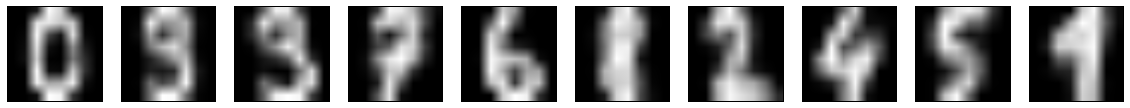

In [85]:
q_z = process(X, num_start=1, alpha=2.5, a=0.99, b=0.88)

In [87]:
rf = RF(n_estimators = 1000)
X_train, X_test, y_train, y_test = train_test_split(q_z, y)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [88]:
print "Accuracy: {0:.3f}".format(accuracy_score(y_pred, y_test))

Accuracy: 0.860


Теперь построим матрицу точности на контрольной выборке и визуализируем ее:

array([[ 46.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.],
       [  0.,  39.,   1.,   0.,   0.,   0.,   0.,   0.,   5.,   2.],
       [  0.,   2.,  41.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   1.,  32.,   0.,   0.,   0.,   0.,   6.,   9.],
       [  0.,   0.,   0.,   0.,  41.,   0.,   0.,   1.,   0.,   0.],
       [  1.,   0.,   0.,   1.,   1.,  50.,   0.,   0.,   1.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  42.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   4.,   2.,   0.,   0.,  44.,   0.,   0.],
       [  0.,   2.,   2.,   5.,   1.,   0.,   0.,   1.,  32.,   1.],
       [  0.,   2.,   0.,   4.,   0.,   2.,   0.,   0.,   1.,  20.]])

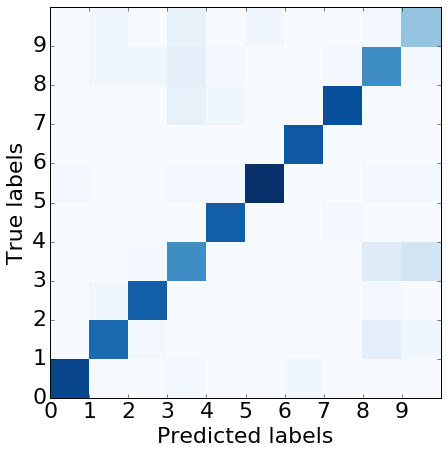

In [90]:
def count_accuracy_matrix(y_pred, y_test):
    matrix = np.zeros((10, 10))
    for i, value in enumerate(y_pred):
        matrix[value][y_test[i]] += 1
        
    f, ax = plt.subplots(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 22})
    heatmap = ax.pcolor(matrix, cmap=plt.cm.Blues)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')
    
    return matrix

count_accuracy_matrix(y_pred, y_test)
    

##### Пятый пункт

In [380]:
def add_nums(X, y, num_start=10, alpha=3, a=0.9, b=0.8):
    dp_mixture = DPMixture(X[y==0], alpha, a, b)
    dp_mixture.var_inference(num_start=num_start, max_iter=100, display=False)
    dp_mixture.show_clusters()
    for label in range(1, 10):  
        dp_mixture.add_sample(X[y==label])
        dp_mixture.var_inference(num_start=num_start, max_iter=100, display=False)
        dp_mixture.show_clusters()

Alpha = 3, a = 0.9, b = 0.8


C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log
C:\Python27\Lib\site-packages\IPython\kernel\__main__.py:39: RuntimeWarning: invalid value encountered in multiply


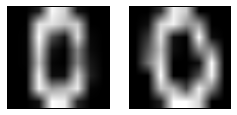

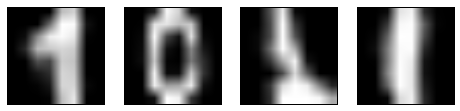

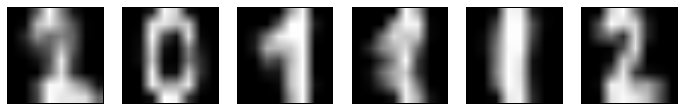

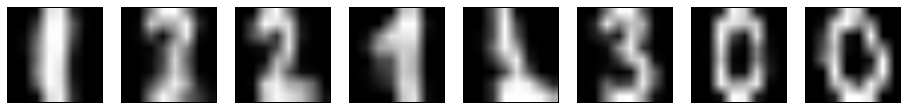

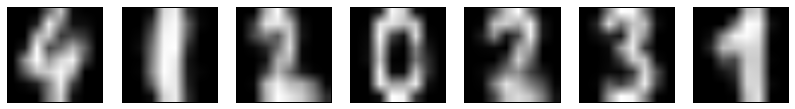

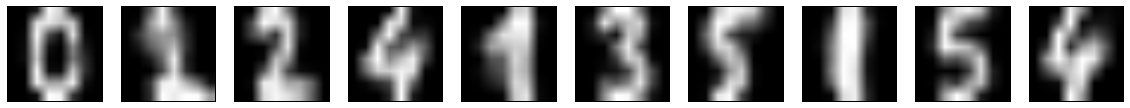

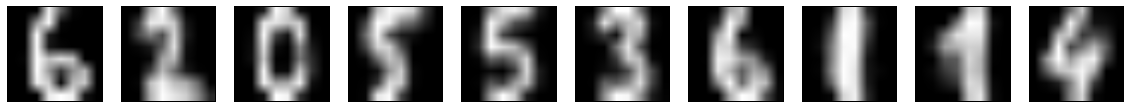

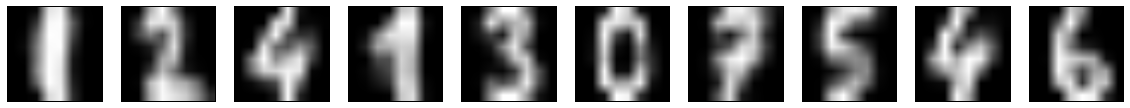

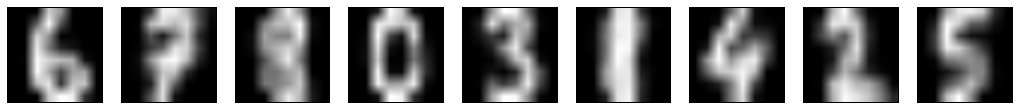

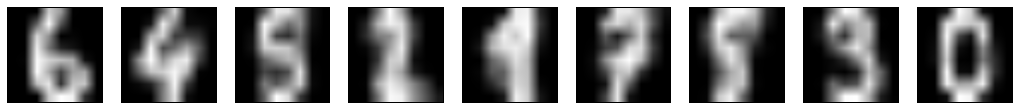

In [381]:
add_nums(X, y)